In [1]:
import numpy as np
import h5py
import treecorr

In [2]:
path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/'


In [3]:
with h5py.File(path+"binned_star_catalog.hdf5",'r') as f:
    b = f['stars/bin_bright/']
    cat_sb = treecorr.Catalog(
                ra=b["ra"][:],
                dec=b["dec"][:],
                ra_units="degree",
                dec_units="degree",
                npatch=40,
            )
    d = f['stars/bin_dim/']
    cat_sd = treecorr.Catalog(
                    ra=d["ra"][:],
                    dec=d["dec"][:],
                    ra_units="degree",
                    dec_units="degree",
                    patch_centers=cat_sb.patch_centers,
            )
with h5py.File(path+"randoms_desy3_RM.hdf5",'r') as f:
    r = f["randoms/"]
    rancat = treecorr.Catalog(
                ra=r["ra"][:],
                dec=r["dec"][:],
                ra_units="degree",
                dec_units="degree",
                patch_centers=cat_sb.patch_centers,
            )

In [4]:
def apply_metacal_response(R, S, g1, g2):
    # The values of R are assumed to already
    # have had appropriate weights included
    from numpy.linalg import pinv
    import numpy as np

    mcal_g = np.stack([g1, g2], axis=1)

    R_total = R + S

    # Invert the responsivity matrix
    Rinv = pinv(R_total)
    mcal_g = Rinv @ mcal_g.T

    return mcal_g[0], mcal_g[1]

In [5]:
path2 = '../../TXPipe/data/desy3/outputs/'
with h5py.File(path2+'shear_tomography_catalog.hdf5','r') as f:
    source_bin = f['tomography/bin'][:]
    mask = source_bin != -1  # Only use the sources that pass the fiducial cuts
    R_total_2d = f['response/R_S_2d'][:] + f['response/R_gamma_mean_2d'][:]

with h5py.File(path+'shear_catalog_desy3_unmasked_withfakez.hdf5','r') as f:
    g = f['shear']
    g1      = g['mcal_g1'][:][mask]
    g2      = g['mcal_g2'][:][mask]
    gw  = g['weight'][:][mask]
    gra,gdec = g['ra'][:][mask], g['dec'][:][mask]

print('Applying metacal/metadetect response')
g1, g2 = apply_metacal_response(R_total_2d, 0.0, g1, g2)


gg = np.array((g1, g2))

Applying metacal/metadetect response


In [6]:
catg = treecorr.Catalog(ra=gra,
                        dec=gdec,
                        g1=gg[0],
                        g2=gg[1],
                        w=gw,
                        ra_units="deg",
                        dec_units="deg",
                        patch_centers=cat_sb.patch_centers) # galaxy shear


In [7]:
config = {"min_sep": 0.5,
        "max_sep": 300.0,
        "nbins": 20,
        "bin_slop": 0.01,
        "sep_units": "arcmin",
        "auto_only": False,
        "var_method": "jackknife",
    }
nsbg = treecorr.NGCorrelation(config)
nsdg = treecorr.NGCorrelation(config)

rg = treecorr.NGCorrelation(config)

In [8]:
nsbg.process(cat_sb, catg, low_mem=True)
nsdg.process(cat_sd, catg, low_mem=True)
rg.process(rancat, catg, low_mem=True)

In [9]:
nsbg.calculateXi(rg=rg)
nsdg.calculateXi(rg=rg)

(array([-2.10526816e-04, -7.15245394e-05, -2.01017834e-05,  5.82081358e-05,
         9.29758196e-05,  1.14901011e-04,  9.45573833e-05,  8.41280278e-05,
         7.92548498e-05,  5.97909054e-05,  5.00298956e-05,  4.28982516e-05,
         3.51316758e-05,  3.09222802e-05,  2.82724926e-05,  2.26665464e-05,
         1.81201705e-05,  1.21370610e-05,  9.69521814e-06,  6.91462455e-06]),
 array([ 7.52529458e-05,  4.45425500e-06, -1.31378905e-05,  4.65813145e-06,
        -9.39131313e-06,  4.77015851e-07,  3.03409866e-06, -4.02190231e-06,
         2.65650032e-07,  3.01423473e-06, -1.79642399e-06,  3.12629218e-07,
        -3.28641329e-06, -4.32158588e-07, -4.56648678e-06, -4.38514743e-06,
        -4.59132425e-06, -2.74922957e-06,  7.76775519e-07,  1.93913929e-09]),
 array([1.27076332e-09, 1.41430244e-09, 6.20500086e-10, 3.05097572e-10,
        1.39948825e-10, 9.04617638e-11, 5.12833587e-11, 5.56498238e-11,
        2.89313968e-11, 1.80252126e-11, 1.84396074e-11, 8.78577231e-12,
        7.60997115e-

In [10]:
nsbg.xi
#nsbg.meanr


array([ 7.36718510e-05,  5.45554179e-04,  1.45483324e-04,  2.51413041e-04,
        6.26704076e-05,  5.40683274e-05,  1.32813951e-04, -4.37355742e-08,
       -6.29189269e-06,  2.12831236e-06,  2.26803214e-05,  1.21967493e-05,
        8.77472458e-06, -1.38167383e-05, -6.40971170e-06,  4.60984253e-06,
        3.43142941e-06, -2.05814122e-07, -6.67329096e-07,  3.22767794e-06])

Text(0.5, 0, '$\\theta$ arcmin')

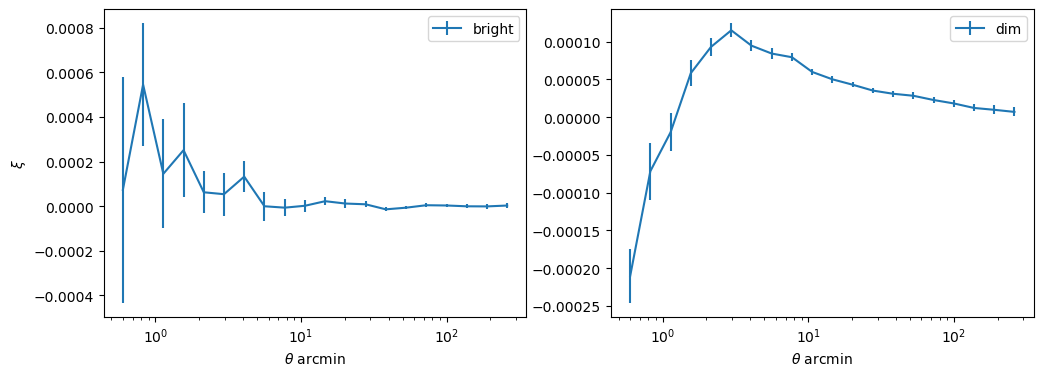

In [11]:
import matplotlib.pyplot as plt
fig, axs  = plt.subplots(1,2, figsize = [12,4])
ax1,ax2 = axs.flatten()
ax1.errorbar(nsbg.meanr,nsbg.xi,nsbg.varxi**0.5,label='bright')
ax1.set_xscale('log')
ax1.legend()
ax1.set_ylabel(r'$\xi$')
ax1.set_xlabel(r'$\theta$ arcmin')

ax2.errorbar(nsdg.meanr,nsdg.xi,nsdg.varxi**0.5,label='dim')
ax2.set_xscale('log')
ax2.legend()
#ax2.set_ylabel(r'$\xi$')
ax2.set_xlabel(r'$\theta$ arcmin')

In [12]:
sb = sacc.Sacc.load_fits('../../TXPipe/data/desy3/outputs/gammat_bright_stars.sacc')
sb_thetaxi = sb.get_theta_xi('galaxyStar_shearDensity_xi_t','source2d','bright_stars')
sb_err = sb.get_tag('error')

sd = sacc.Sacc.load_fits('../../TXPipe/data/desy3/outputs/gammat_dim_stars.sacc')
sd_thetaxi = sd.get_theta_xi('galaxyStar_shearDensity_xi_t','source2d','dim_stars')
sd_err = sd.get_tag('error')


NameError: name 'sacc' is not defined

In [ ]:
import matplotlib.pyplot as plt
fig, axs  = plt.subplots(1,2, figsize = [12,4])
ax1,ax2 = axs.flatten()
ax1.errorbar(nsbg.meanr,nsbg.xi,nsbg.varxi**0.5,label='bright')
ax1.errorbar(sb_thetaxi[0],sb_thetaxi[1],sb_err,marker='x',color='blue',linestyle='None',label='TXPipe')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\xi$')
ax1.set_xlabel(r'$\theta$ arcmin')
ax1.legend()


ax2.errorbar(nsdg.meanr,nsdg.xi,nsdg.varxi**0.5,label='dim')
ax2.errorbar(sd_thetaxi[0],sd_thetaxi[1],sd_err,marker='_',color='chocolate',linestyle='None',label='TXPipe')
ax2.set_xscale('log')
#ax2.set_ylabel(r'$\xi$')
ax2.set_xlabel(r'$\theta$ arcmin')
ax2.legend()